In [2]:
import os
import gc
import sys
import pdb
import copy
import glob
import psutil
import imageio
import calendar
import importlib
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib as mpl
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
from memory_profiler import memory_usage
from matplotlib.patches import Rectangle
from cftime import DatetimeNoLeap as date
from matplotlib.colors import TwoSlopeNorm
from matplotlib.dates import DateFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams.update({
    'font.size'       : 14,   # Base font size
    'axes.labelsize'  : 14,   # Axis labels
    'xtick.labelsize' : 12,   # X-axis tick labels
    'ytick.labelsize' : 12,   # Y-axis tick labels
    'legend.fontsize' : 12,   # Legend font size
    'figure.titlesize': 16    # Figure title size
})
plt.ioff()
#mpl.use('Agg')
#%matplotlib agg

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/TEM/limvar_analysis_NERSC')
import plotting_utils as putil
import compute_ensemble_stats as ces
importlib.reload(putil)
importlib.reload(ces)
fix_dtint   = putil.adjust_10daily_integrated_tendency
shift_dtint = putil.shift_integrated_tendency
sig         = putil.filter_significance
cmn         = putil.get_cmap_norm

sys.path.insert(1, '/global/homes/j/jhollo/repos/climate_analysis/CLDERA/wavePaperFigs/util')
import nclcmaps as ncm

In [3]:
importlib.reload(putil)
importlib.reload(ces)
from IPython.display import clear_output

# ----- get data
latmin, latmax = 30, 50
tmin, tmax = date(1991,6,1), date(1993,7,2)
#kwargs = {'freq':'10daily', 'return_intersection':False, 'return_members':True, 'skip_nosrctag':False, 'latmin':latmin, 'latmax':latmax, 'mass':10}
#u_           = putil.get_variable('U', **kwargs)

#kwargs = {'freq':'10daily', 'return_intersection':False, 'return_members':True, 'skip_nosrctag':True, 'latmin':latmin, 'latmax':latmax, 'mass':10}
#u_           = putil.get_variable('U', **kwargs)

kwargs = {'freq':'10daily', 'return_intersection':False, 'return_members':True, 'skip_nosrctag':True, 'mass':10,
          'latmin':latmin, 'latmax':latmax, 'tmin':tmin, 'tmax':tmax, 'average_lat':True, 'average_pres':False, 'average_time':False}
u_ = putil.get_variable('U', **kwargs)

clear_output()
print('done')

done


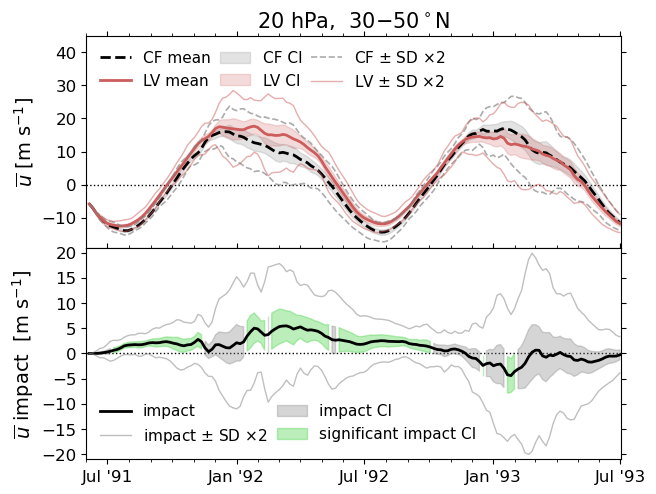

In [4]:
importlib.reload(putil)
importlib.reload(ces)

# --- make figure
fig = plt.figure(figsize=(6.9, 5.5))
gs = GridSpec(2, 1, height_ratios=[1, 1], figure=fig)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# ---- get dims and data
p = 20
plev = u_['cfmean'].plev
time = u_['cfmean'].time
time = putil.to_datetime(time)
N    = len(u_['members'].ens)

u = copy.deepcopy(u_)
for dset in u_.keys():
    u[dset] = u_[dset].sel(plev=p, method='nearest')

# ----- plotting settings
topt = {'option':'solstice', 'include_year':True}
tlim = [datetime(tmin.year,tmin.month,tmin.day),datetime(tmax.year,tmax.month,tmax.day)]
cf_color, cf_ls = 'k', '--'
cf_std_color    =  'grey'
color, ls       = 'indianred', '-'
std_color       = color
sig_color       = 'limegreen'

# -------- get data
# -- pinatubo
pvi      = u['ensmean']
pvi_mems = u['members']
pvi_std  = pvi_mems.std('ens')
# -- counterfactual
cf_pvi      = u['cfmean']
cf_pvi_mems = u['cf_members']
cf_pvi_std  = cf_pvi_mems.std('ens')
# -- impact
impact_pvi      = u['impact']
impact_p        = u['pval']
impact_pvi_mems = pvi_mems - cf_pvi_mems
impact_pvi_std  = impact_pvi_mems.std('ens')
# -- confidence intervals
ci        = putil.confidence_interval(pvi, pvi_std, N, 0.05) 
cf_ci     = putil.confidence_interval(cf_pvi, cf_pvi_std, N, 0.05) 
impact_ci = putil.confidence_interval(impact_pvi, impact_pvi_std, N, 0.05) 
  
# ========= plot winds
# ----- plot mean winds at 10 hPa
ax1.plot(time, cf_pvi, color=cf_color, lw=2, ls=cf_ls, label='CF mean')
ax1.plot(time, pvi, color=color, lw=2, ls=ls, label='LV mean')
# ---- plot confidence intervals
ax1.fill_between(time, y1=cf_ci[0], y2=cf_ci[1], color=cf_std_color, alpha=0.22, label='CF CI')
ax1.fill_between(time, y1=ci[0], y2=ci[1], color=std_color, alpha=0.22, label='LV CI')
# ---- plot standard deviations
for stdf in [-2, 2]:
    if(stdf==-2): 
        cf_label = 'CF $\\pm$ SD $\\times 2$'
        label    = 'LV $\\pm$ SD $\\times 2$'
    else:
        cf_label, label = None, None
    ax1.plot(time, cf_pvi-cf_pvi_std*stdf, color=cf_std_color, alpha=0.66, ls=cf_ls, lw=1.2, label=cf_label)
    ax1.plot(time, pvi-pvi_std*stdf, color=std_color, alpha=0.5, lw=1, ls=ls, label=label)
    
# ========= plot wind impacts
# ----- plot mean winds at 10 hPa
ax2.plot(time, impact_pvi, '-', color='k', lw=2, label='impact')
# ---- plot standard deviations
for stdf in [-2, 2]:
    if(stdf==-2): 
        label    = 'impact $\\pm$ SD $\\times 2$'
    else:
        label = None
    ax2.plot(time, impact_pvi-impact_pvi_std*stdf, color='grey', alpha=0.5, lw=1, ls=ls, label=label)
# ---- plot confidence intervals
ax2.fill_between(time, y1=impact_ci[0].where(impact_p>0.05), y2=impact_ci[1].where(impact_p>0.05), color='grey', alpha=0.33, label='impact CI')
ax2.fill_between(time, y1=impact_ci[0].where(impact_p<=0.05), y2=impact_ci[1].where(impact_p<=0.05), color=sig_color, alpha=0.33, label='significant impact CI')
    
# ---- shade significant regions


# ----- format plot 
for ax in [ax1, ax2]:
    ax.axhline(y=0, ls=':', color='k', lw=1, zorder=0)
    ax.set_xlim(tlim)
    putil.season_timeticks(ax, time, **topt)

ax1.yaxis.set_ticks(np.arange(-20, 71, 10))
ax1.set_ylim([-19, 45])
putil.format_ticks(ax1, x=None)
putil.format_ticks(ax)
ax1.set_ylabel('$\\overline{{u}}$ [m s$^{-1}$]')
ax1.legend(loc='upper left', frameon=False, fancybox=False, edgecolor='k', ncol=3, fontsize=11, columnspacing=0.6)
plabel = '{} hPa,  {}$-${}$^\\circ$N'.format(p, latmin, latmax)
ax1.set_title(plabel, loc='center', fontsize=15)

ax2.yaxis.set_ticks(np.arange(-40, 35, 5))
ax2.set_ylim([-21, 21])
ax2.set_ylabel('$\\overline{{u}}$ impact  [m s$^{-1}$]')
ax2.legend(loc='lower left', frameon=False, fancybox=False, edgecolor='k', ncol=2, fontsize=11, columnspacing=0.6)

plt.subplots_adjust(hspace=0)

plt.savefig('figs/PVI_impact_spread.pdf', dpi=250)
plt.show()

In [93]:
t0, t1, t2 = date(1992,2,1), date(1992,3,1), date(1992,4,1)
kwargs = {'freq':'monthly', 'return_intersection':False, 'return_members':True, 'skip_nosrctag':True, 'mass':10,
          'tmin':t0, 'tmax':t1, 'average_time':True}
uuu = putil.get_variable('U', **kwargs)
clear_output()
print('done')

done


Text(0, 1.62, "Feb$-$Mar '92")

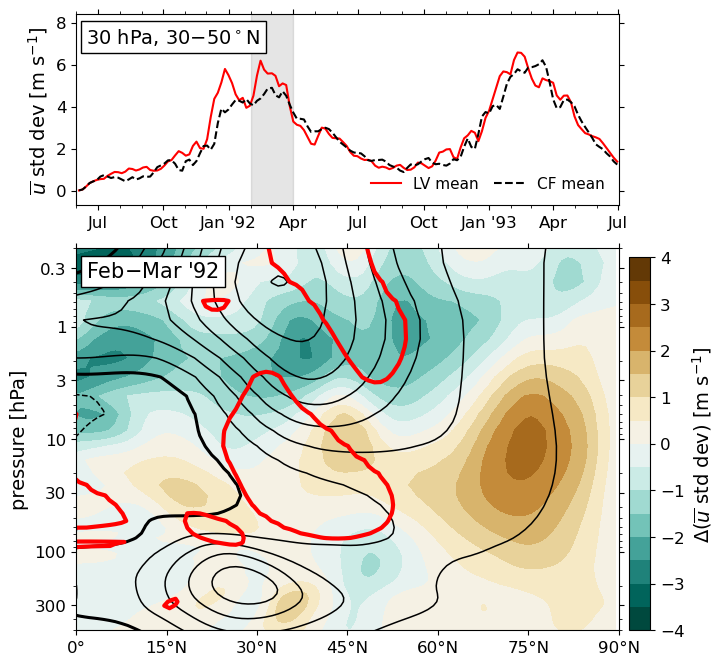

In [164]:
importlib.reload(putil)
importlib.reload(ces)

# -- pinatubo
uu = uuu['ensmean']
uu_p = uuu['pval']
uu_mems = uuu['members']
uu_std  = uu_mems.std('ens')
# -- counterfactual
uucf      = uuu['cfmean']
uucf_mems = uuu['cf_members']
uucf_std  = uucf_mems.std('ens')

fig = plt.figure(figsize=(7,8))
gs = GridSpec(2,1,height_ratios=[0.5,1], hspace=0.15)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax1.plot(time, pvi_std, color='r', lw=1.5, label='LV mean')
ax1.plot(time, cf_pvi_std, color=cf_color, ls=cf_ls, lw=1.5, label='CF mean')
#ax1.plot(time, pvi_std-cf_pvi_std, '-k')
ax1.set_xlim([tmin,tmax])
ax1.set_ylim([-0.7, 8.4])
ylim = ax1.get_ylim()
ax1.fill_between([t0,t2], y1=ylim[0], y2=ylim[1], color='k', alpha=0.1)
ax1.set_ylim(ylim)
putil.season_timeticks(ax1, time, 'season', include_year=True, year_on_jan_only=True)
putil.format_ticks(ax1)
ax1.set_ylabel('$\\overline{u}$ std dev [m s$^{-1}$]')
ax1.legend(loc='lower right', frameon=False, fancybox=False, edgecolor='k', ncol=2, fontsize=11, columnspacing=1)

levels=np.arange(-4,4.1,0.5)
scc = ax2.contourf(uu.lat, uu.plev, (uu_std-uucf_std).T, levels=levels, cmap='BrBG_r', norm=putil.get_cmap_norm(levels, 'twoslope'))
ax2.contour(uu.lat, uu.plev, uucf.T, colors='k', levels=np.arange(-70,71,10), linewidths=1.1)
ax2.contour(uu.lat, uu.plev, uucf.T, colors='k', levels=[0], linewidths=2.2)
ax2.contour(uu.lat, uu.plev, uu_p.T, colors='r', levels=[0.05], linewidths=3)

cbheight = 0.466
cbpos = [0.915, 0.11, 0.03, cbheight] # colorbar position
cax=fig.add_axes(cbpos)
cb = plt.colorbar(scc, cax=cax, location='right', label='$\\Delta$($\\overline{u}$ std dev) [m s$^{-1}$]')
ax2.set_ylim([0.2,500])
putil.format_paxis(ax2)
ax2.set_xlim([0,89])
putil.format_ticks(ax2)
ax2.set_ylabel('pressure [hPa]')
putil.format_lataxis(ax2, ticks=np.arange(0,91,15))

ax1.text(0, 2.73, '30 hPa, 30$-$50$^\\circ$N', transform=ax.transAxes, verticalalignment='top', 
         fontsize=14, zorder=1000, bbox=dict(facecolor='w', edgecolor='k'))
ax2.text(0, 1.62, 'Feb$-$Mar \'92', transform=ax.transAxes, verticalalignment='top', 
         fontsize=15, zorder=1000, bbox=dict(facecolor='w', edgecolor='k'))